This notebook showcases a PyTorch Transformer model applied to quantitative modeling using a Transformer model

*  This transformer model is Non-Autoregressive: The entire input sequence is processed all at once and I don't hide the future information. It means, they are fully observed input sequences.
*  It will predict sequences that are also fully visible when training the model.
*  To keep it simple, I used only one stock price (Equity Index SP500), and a limited number of features:
    *  low || high || open || close || volume || upper_bb50_3 || ATR14 || rsi || MA50 || wvma50 || lower_bb50_3 || log_return[close].
    *  These features are momentum and trend based, but mostly are techinical signals. A more thorough analysis will include more fundamental features like P/E ratio, Liquidity, Return on Equity, ...
    *  I added the log return in my input (not output). It should introduce a better notion of directionality. In theory, it also leads to better results and less skewness.
    *  Log_return is not used as an output here because:
        *  This approach is unique because I am not approaching the modeling like LSTM would do. But with sequences. In order to add more data, I ended up creating different set of sequences.









*   For illustrative below, are examples of how the input sequences (Green) and ouput sequences (Blue) would be created. Different sequence lengths, different output lenghts, and different shifts.


| Seq Lgth 5, shift 3, tgt length 2  | Seq Lgth 8, shift 6, tgt length 3  | Seq Lgth 14, shift 1, tgt length 14  |
| ------------- | ------------- | ------------- |
| 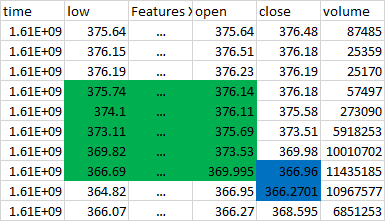  | 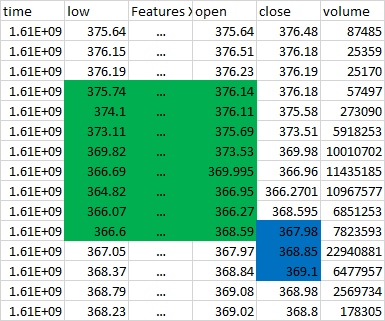  | 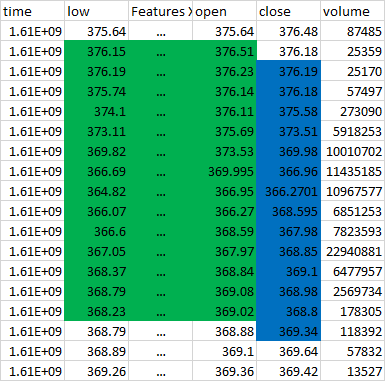  |


*   Because of these various sequences lengths and the different targets structures, it wasn't possible to use log_return as an output the way I built the model. It should be possible but I would have to use a fixed length for each sequences and targets.


        
*   Future work = Improve the model: Multi Variate and Multi timeframes. It is pretty easy add more features for more stocks, but it will clearly make the model pretty big and go beyond the scope fof showcasing the skills.

*   I have built another transformer model, much more complicated, that uses options chains (strike, expiration, day to earnings, premium, ... ) that is a classifier, still with a transformer architecture. And combine these two models would actually be pretty great.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from timeit import default_timer as timer
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
from itertools import groupby
import json, math
import re, sys
import time
from time import sleep
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import time
from time import sleep

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 99)
pd.set_option('max_colwidth', None)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: None]


Data come from Trading view. I exported a sample of historical values of SPY on the hourly TF.
The inference csv file is from some weeks later.
I set up a sequence length of 10 Time Steps (TS) and a shift of 1 TS.

Data come from TradingView for SPY

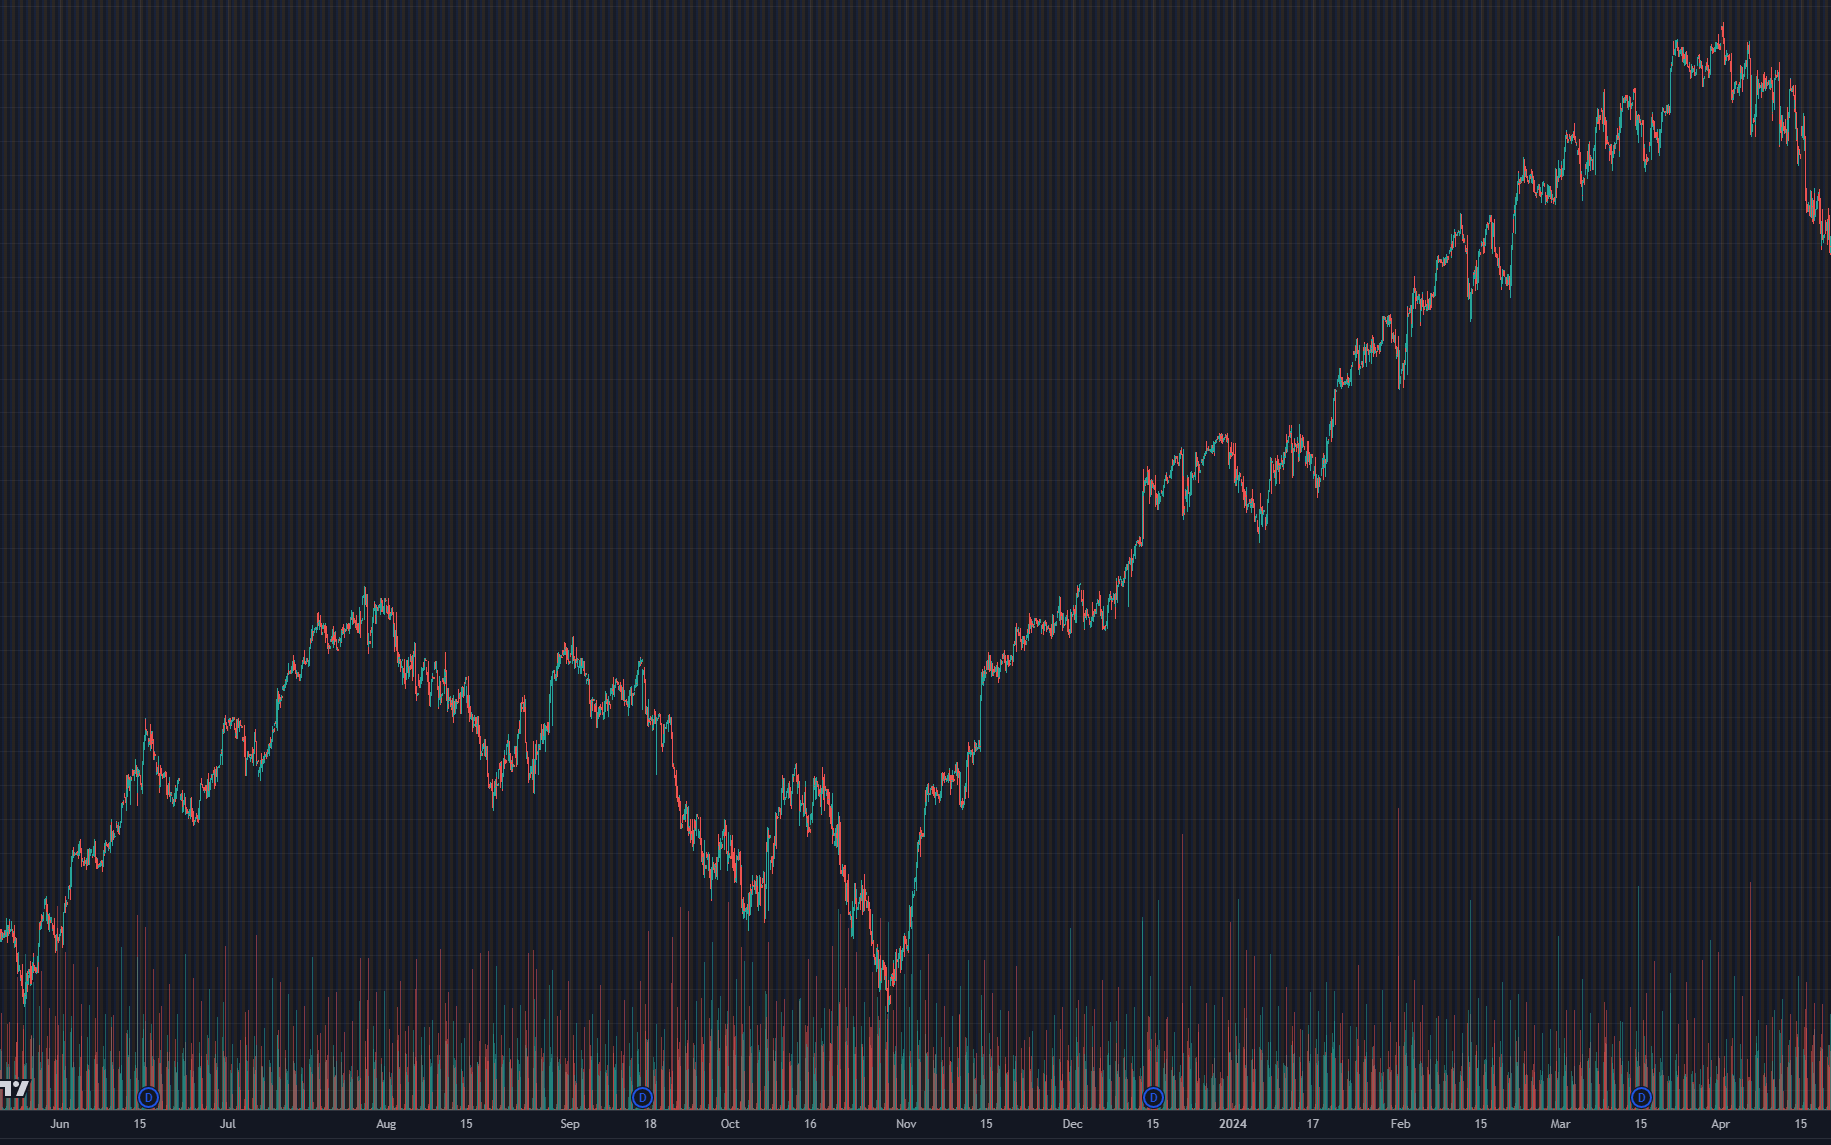

I was able to export around 13000 rows of candlesticks and volumes

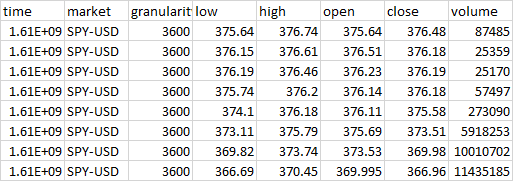

Below: I created some indicator from a library of Technical Indicators I have. I kept it succinct, and in this case I will use Moving Average using last 50 time steps, RSI - 14 time steps, Boilinger Bands with a standard deviation of 3 and 50 previous ts for MA, Average True Range (14 time steps), Weighted Volume Moving Average (50 TS).

In [2]:
# @title Creating TA indicators
class TechnicalAnalysis():
    def __init__(self, data):
        if not isinstance(data, pd.DataFrame):
            raise TypeError('Data passed is not a Dataframe')

        print(data.head(4))
        if list(data.columns.values) != [ 'date', 'market', 'granularity', 'low', 'high', 'open', 'close', 'volume' ]:
            raise TypeError('Dataframe does not contain the right headers')

        self.df = data

    def returnDF(self):
        return self.df

    def getData(self):
        self.MA50 = self.movingAverage(50)
        self.rsi(14)
        self.averageTrueRange(14)
        self.weightedVolumeMovingAverage(50)
        self.bollingerBands(50, 3)

######################
    def movingAverage(self, period):
        if not isinstance(period, int):
            raise TypeError('Period is not an int')
        colName = 'MA'+str(period)
        self.df[colName] = self.df['close'].rolling(window=period, min_periods=0).mean()
        return self.df

    def averageTrueRange(self,period):
        if not isinstance(period, int):
            raise TypeError('Period is not an int')

        colName = 'ATR' + str(period)
        self.df['todayHighMinLow'] = self.df['high'] - self.df['low']
        self.df['todayHighMinYestClose'] = self.df['high'] - self.df['close'].shift()
        self.df['yestCloseMinTodayLow'] = self.df['close'].shift() - self.df['low']
        self.df['maxVal'] = self.df[['todayHighMinLow', 'todayHighMinYestClose', 'yestCloseMinTodayLow']].max(axis=1)
        self.df[colName] = self.df['maxVal'].ewm(span=period, min_periods=period, adjust=False, ignore_na=False).mean()
        self.df[colName] = self.df[colName].fillna(0)
        return self.df

    def weightedVolumeMovingAverage(self, period):
        if not isinstance(period, int):
            raise TypeError('Period is not an int')
        colNameA = 'wvmaA' + str(period)
        colName = 'wvma' + str(period)
        self.df[colNameA] = (self.df['close'])*(self.df['volume'])
        self.df[colName] = self.df[colNameA].rolling(window=period, min_periods=0).mean()/self.df['volume'].rolling(window=period, min_periods=0).mean()
        return self.df
    def rsi(self, period):

        if not isinstance(period, int):
            raise TypeError('Period is not an int')
        close = self.df['close'].diff()
        up = close.clip(lower=0).abs()
        down = close.clip(upper=0).abs()
        self.df['rsi'] = 100 - (100 / (1 + up.ewm(period).mean() / down.ewm(period).mean()))
        self.df['rsi'] = self.df['rsi'].fillna(0)
        return self.df

    def bollingerBands(self, period, std):
        if not isinstance(period, int):
            raise TypeError('Period is not an int')

        colName1 = 'MA' + str(period)
        if colName1 not in self.df:
            sma = self.movingAverage(period)
        sma = self.df[colName1]
        stdDev = std
        colName = 'upper_bb'+str(period)+'_'+str(std)
        colName2 = 'lower_bb' + str(period)+'_'+str(std)

        self.df[colName] = sma + stdDev*self.df['close'].rolling(window=period).std()
        self.df[colName2] = sma - stdDev*self.df['close'].rolling(window=period).std()

        return self.df

In [6]:
# @title Load Data and set Params
start = time.time()

def dfTradingAnalysis(df):
    start = time.time()
    histTradingDataCopy = df.copy()
    ta = TechnicalAnalysis(histTradingDataCopy)
    ta.getData()
    df = ta.returnDF()
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df = df.drop('market', axis=1, inplace=False)
    df = df[['date', 'low', 'high', 'open', 'close', 'volume', 'upper_bb50_3','ATR14', 'rsi', 'MA50', 'wvma50', 'lower_bb50_3']]
    end = time.time()
    print(end -start)
    return df

try:
    file_path = "/content/drive/Othercomputers/My Laptop/Documents/60mn_Training2.csv"
    data = pd.read_csv(file_path)
    file_inf = "/content/drive/Othercomputers/My Laptop/Documents/60mn_Inference6.csv"
    data_inf = pd.read_csv(file_inf)
    # Rename the 'time' column to 'date'
    data.rename(columns={'time': 'date'}, inplace=True)
    for col in data:
        if (col != 'market'):  # Skip the 'market' column
            data[col] = pd.to_numeric(data[col], errors='coerce')

    length_file1 = data.shape[0]
    data_pp = dfTradingAnalysis(data.tail(length_file1 - 1))
    data_pp = data_pp.dropna()

except Exception as e:
    print(e)
    print('\tlost connection')
    sleep(10)

###########################################################
#Adding Log Close Returns as input only
shift_start_val = 0
shift_n = 1
# # Calculate deltas using the previous forecast_length value
def create_new_columns(data, shift_value, start):
  for i in range(start, shift_value + start):
    data[f"delta_vol{i+1}"] = data["volume"].pct_change(periods=i+1) * 100
  return data

data_pp = create_new_columns(data_pp, shift_n, shift_start_val)
data_pp = data_pp.dropna()

# Calculate log returns
data_pp['log_return'] = np.log(data_pp['close'] / data_pp['close'].shift(1))

# Handle NaN values - drop the first row or fill NaN with 0
data_pp.dropna(subset=['log_return'], inplace=True)
###########################################################

range_rows = data_pp.shape[0]
range_cols = data_pp.shape[1]
print("Number rows:", range_rows)
print("Number Cols:", range_cols)

########################################################################################
input_data = []
output_data = []
date_data = []

batch_size = 4096
padding_values = 100
num_epochs = 80
emb_size = 256
dim_fwd = 256
nhead = 2
num_enc_layer = 1
num_dec_layer = 1
lr = 1e-3
################################
# Values used for inference - can be modified
input_seq_length = 10
forecast_length = 3
output_seq_length = 8
################################
train_test_split_val = 0.2
train_val_split_val = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Now using device: {device}")

#################################
src_size = range_cols - 2 #minus date and close
######
features_number = range_cols - 1 #minus close
################################

         date   market  granularity     low    high    open   close  volume
1  1609754400  SPY-USD         3600  376.15  376.61  376.51  376.18   25359
2  1609758000  SPY-USD         3600  376.19  376.46  376.23  376.19   25170
3  1609761600  SPY-USD         3600  375.74  376.20  376.14  376.18   57497
4  1609765200  SPY-USD         3600  374.10  376.18  376.11  375.58  273090
0.0402224063873291
Number rows: 13259
Number Cols: 14
Now using device: cuda


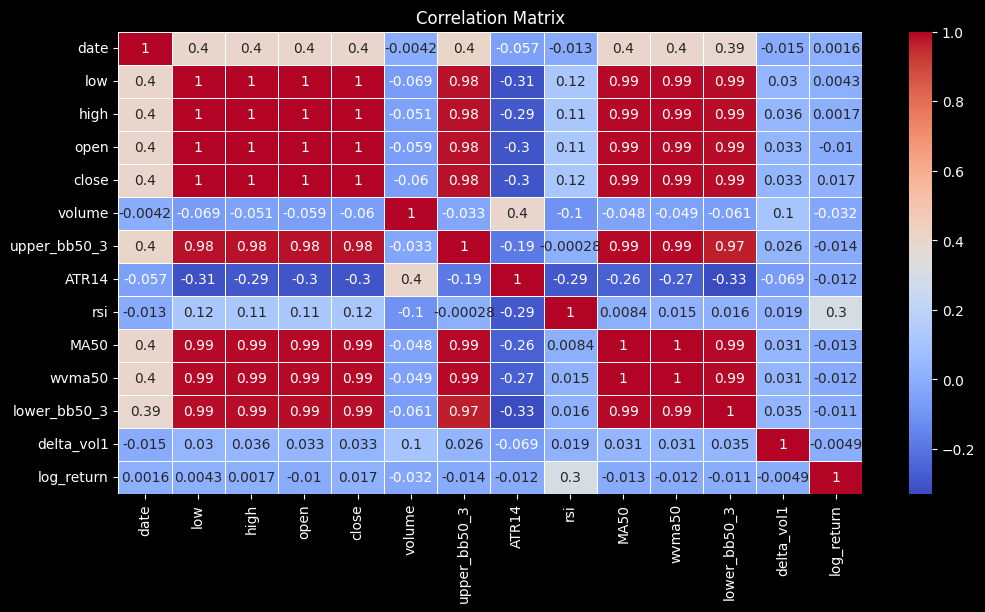

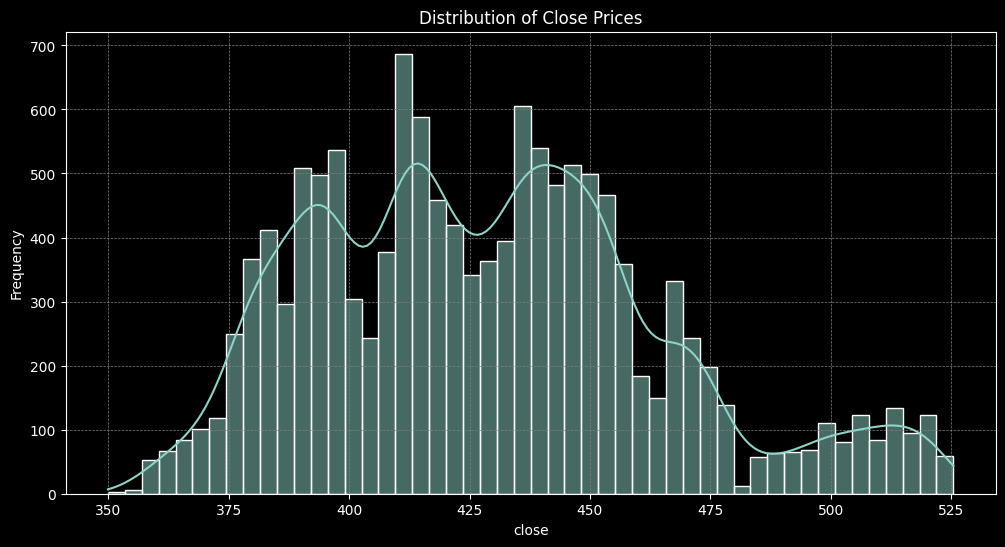

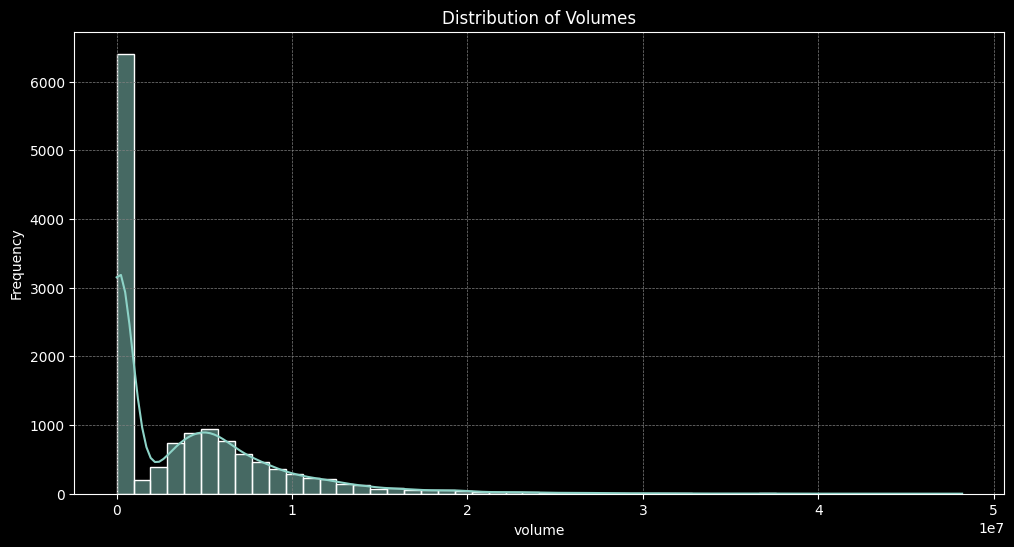

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = data_pp.corr()

# Plot the correlation matrix
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

def plot_distribution(data, column, title):
    plt.figure(figsize=(12, 6))
    sns.histplot(data[column], bins=50, kde=True)
    plt.title(f'Distribution of {title}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.show()

# Plot distribution of 'Close' values
plot_distribution(data_pp, 'close', 'Close Prices')

# Plot distribution of 'Volume' values
plot_distribution(data_pp, 'volume', 'Volumes')

In [8]:
#If log used, then last dim must be > 2
combinations = [
    (5, 3, 2),
    (8, 6, 3),
    (10, 1, 10),
    (5, 1, 5),
    (14,1,14),
    (16, 8 ,10)
]

input_data = []
output_data = []
date_data = []

# Generate sequences
for input_seq_length, forecast_length, output_seq_length in combinations:
    print(f"Created sequences input_seq_length: {input_seq_length}, shift target length: {forecast_length}, output_seq_length: {output_seq_length}")
    for start_idx in range(len(data_pp) - input_seq_length - forecast_length):
        if start_idx + input_seq_length >= len(data_pp):
            break
        sequence_input = data_pp.drop(columns=['close']).iloc[start_idx:start_idx + input_seq_length, 1:features_number].values.tolist()
        sequence_output_value = data_pp['close'].iloc[start_idx + forecast_length:start_idx + input_seq_length + forecast_length].values

        if len(sequence_output_value) >= output_seq_length:
            date = data_pp.iloc[start_idx, 0]
            input_data.append(sequence_input)
            output_data.append(sequence_output_value[:output_seq_length])
            date_data.append(date)

Created sequences input_seq_length: 5, shift target length: 3, output_seq_length: 2
Created sequences input_seq_length: 8, shift target length: 6, output_seq_length: 3
Created sequences input_seq_length: 10, shift target length: 1, output_seq_length: 10
Created sequences input_seq_length: 5, shift target length: 1, output_seq_length: 5
Created sequences input_seq_length: 14, shift target length: 1, output_seq_length: 14
Created sequences input_seq_length: 16, shift target length: 8, output_seq_length: 10


In [9]:
def convertListtoDf(input_data, output_data, date_data):
    listTo_df = pd.DataFrame({
        'date': date_data,
        'input': input_data,
        'output': output_data
    })
    # print(listTo_df.shape)
    # print(listTo_df.head())
    return listTo_df

final_df = convertListtoDf(input_data, output_data, date_data )

In [ ]:
# @title Export and Load sequence lenght to avoid recreating them if needed

# # Save the DataFrame to a HDF5  file
# final_df.to_hdf("/content/drive/Othercomputers/My Laptop/Documents/sequences_LOG.parquet", key='df', mode='w')

# # Load the DataFrame from the HDF5 file
# final_df = pd.read_hdf("/content/drive/Othercomputers/My Laptop/Documents/sequences_LOG.parquet", key='df')


                 date  \
0 2021-01-07 13:00:00   
1 2021-01-07 14:00:00   
2 2021-01-07 15:00:00   
3 2021-01-07 16:00:00   
4 2021-01-07 17:00:00   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [10]:
# @title MinMaxScaler applied
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

def applyScalerInOut(df, input_scaler, output_scaler):

    flattened_inputs = np.array([item for sublist in df['input'].values for item in sublist])
    flattened_outputs = np.array([item for sublist in df['output'].values for item in sublist])

    input_scaler.fit(flattened_inputs)
    output_scaler.fit(flattened_outputs.reshape(-1, 1))

    df['scaled_input'] = df['input'].apply(lambda x: input_scaler.transform(x))
    df['scaled_output'] = df['output'].apply(lambda x: output_scaler.transform(np.array(x).reshape(-1, 1)).flatten())
    return df

final_df_scaled=applyScalerInOut(final_df, input_scaler, output_scaler)

*    I set the sequence creation with the opportunity to define the length of the output sequence.
Hence, we can set the length of the input, independently of the length of the ouput.
This mean that in the event, input and ouput have a different sequence lengths, then we will need to add some padding to train the model thw way we set it up (input and output with same length).


*    Shuffling: We are working on time series, yes. But we are maintenaing the temporal order of fully observed sequence. Meaning, I am not training the model to predict the future per say, I am training the model on a structure a,b,c,d,e,f to predict g,h,i sequence structure. So I will shuffle my training and validation data. But I will not shuffle the test data since I want to observe my model on a sequence.

In [11]:
# Define the padding function
def pad_sequences(sequences, max_len, padding_values):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_len:
            if seq.ndim == 1:
                padded_seq = np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=padding_values)
            else:
                padded_seq = np.pad(seq, ((0, max_len - len(seq)), (0, 0)), 'constant', constant_values=padding_values)
        else:
            padded_seq = seq
        padded_sequences.append(padded_seq)
    return padded_sequences

# Determine the maximum sequence lengths for input and output
max_input_len = max(len(seq) for seq in final_df_scaled['scaled_input'])
max_output_len = max(len(seq) for seq in final_df_scaled['scaled_output'])
max_pad_length = max(max_input_len, max_output_len)
print("Max Sequence length used for Padding: ", max_pad_length)

# Pad the sequences
padded_inputs = pad_sequences(np.array(final_df_scaled['scaled_input'].tolist(), dtype=object), max_pad_length, padding_values)
padded_outputs = pad_sequences(np.array(final_df_scaled['scaled_output'].tolist(), dtype=object), max_pad_length, padding_values)

final_df_scaled_pad = final_df_scaled.copy()
# Add the padded sequences back to the DataFrame
final_df_scaled_pad['padded_input'] = pd.Series(padded_inputs)
final_df_scaled_pad['padded_output'] = pd.Series(padded_outputs)

# Print the final DataFrame with padded sequences
# print(final_df_scaled_pad[['date', 'input', 'scaled_input','padded_input', 'output', 'scaled_output', 'padded_output']].head())

Max Sequence length used for Padding:  16


In [ ]:
# @title DataLoader: Create tensors and make sure they have the right lengths.  Then it will send batches of data for training
class FinancialDataset(Dataset):
    def __init__(self, dataframe, padding_values=0.0):
        self.data = dataframe
        self.data.fillna(method='ffill', inplace=True)
        self.padding_values = padding_values
        self.max_len = self.calculate_max_length()

    def create_tensor(self, data):
        if not isinstance(data, list):
            data = data.tolist()
        input_array = np.array(data, dtype=np.double)
        tensor = torch.tensor(input_array, dtype=torch.get_default_dtype())
        return tensor

    def calculate_max_length(self):
        max_input_len = max(len(seq) for seq in self.data['padded_input'])
        max_output_len = max(len(seq) for seq in self.data['padded_output'])
        return max(max_input_len, max_output_len)

    def pad_sequence2(self, sequence, max_len, padding_values):
        if isinstance(sequence[0], (float, int)):
            sequence = [[s] for s in sequence]
        padded = np.full((max_len, len(sequence[0])), padding_values, dtype=np.float32)
        padded[:len(sequence)] = sequence
        return torch.tensor(padded)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        features = self.create_tensor(row['padded_input'])
        padded_output = self.pad_sequence2(row['padded_output'], self.max_len, self.padding_values)
        target = torch.tensor(padded_output, dtype=torch.float32)
        return features, target

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)

    src_tensor = pad_sequence(src_batch, padding_value=padding_values).to(device)
    tgt_tensor = pad_sequence(tgt_batch, padding_value=padding_values).to(device)
    return src_tensor, tgt_tensor

train_val_data, test_data = train_test_split(final_df_scaled_pad, test_size=train_test_split_val, random_state=None, shuffle=False)
train_data, val_data = train_test_split(train_val_data, test_size=train_val_split_val, random_state=42, shuffle=True)

print("Dataframe Shape ",final_df_scaled_pad.shape,"Train Shape ", train_data.shape, "Test Shape ",test_data.shape, "Val Shape ",val_data.shape)

train_dataset = FinancialDataset(train_data, padding_values)
val_dataset = FinancialDataset(val_data, padding_values)
test_dataset = FinancialDataset(test_data, padding_values)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Used for display what the Dataloader sends
for i, (inputs, targets) in enumerate(train_loader):
    torch.set_printoptions(threshold=10000)
    print(f"Batch {i + 1}")
    print("Inputs shape:", inputs.shape)
    print("Targets shape:", targets.shape)
    if i == 0:
        break

Dataframe Shape  (79476, 7) Train Shape  (50864, 7) Test Shape  (15896, 7) Val Shape  (12716, 7)
Batch 1
Inputs shape: torch.Size([16, 4096, 12])
Targets shape: torch.Size([16, 4096, 1])


The model includes:
*   Positional Encoding
*   decoder layers that can be stacked with "num_decoder_layers"
*   Generate_square_subsequent_mask not needed here since we use a non-autoregressive model
*   Customized mae function.

*   The model will ouput the following metrics during the epochs: MSE, MAE



In [ ]:
# @title Model and Run
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, max_seq_len: int = 512):
        super(PositionalEncoding, self).__init__()

        div_term = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, max_seq_len).unsqueeze(1)
        pos_embedding = torch.zeros(max_seq_len, emb_size)
        pos_embedding[:, 0::2] = torch.sin(pos * div_term)
        pos_embedding[:, 1::2] = torch.cos(pos * div_term)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, x: Tensor):
        return self.dropout(x + self.pos_embedding[:x.size(0), :])

# Droupout value increased to try to limit overfitting
class StockTransformer(nn.Module):
    def __init__(self,num_encoder_layers: int, num_decoder_layers:int, emb_size: int,nhead: int,src_size: int,tgt_size: int,dim_feedforward: int,dropout: float = 0.4):
        super(StockTransformer, self).__init__()

        self.emb_size = emb_size
        self.project_src = nn.Linear(src_size, emb_size)
        self.PositionalEncoding = PositionalEncoding(self.emb_size, dropout=dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.emb_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder=nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        # Stack the sequence of layers in the decoder
        decoder_layers = []
        for _ in range(num_decoder_layers):
            decoder_layers.extend([
                nn.Linear(emb_size, dim_feedforward),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        decoder_layers.append(nn.Linear(dim_feedforward, tgt_size))

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, src, src_padding_mask):
        src_emb = self.PositionalEncoding(self.project_src(src) * math.sqrt(self.emb_size))
        memory = self.transformer_encoder(src_emb,  src_key_padding_mask=src_padding_mask)
        output = self.decoder(memory)
        return output

    # # Not needed with this setup
    # def generate_square_subsequent_mask(self,sz):
    #     mask = (torch.triu(torch.ones((sz,sz), device=device)) == 1).transpose(0,1)
    #     mask = mask.float().masked_fill(mask==0, float('inf'))
    #     return mask

def create_src_padding_mask(src, padding_values, device):
    src_pad = torch.full((1, src.shape[2]), fill_value=padding_values, dtype=src.dtype, device=device)
    src_padding_mask = torch.all(src == src_pad, dim=2).transpose(0, 1).to(device)
    return src_padding_mask

def customized_mae(output, tgt):
    preds = output.cpu().detach().numpy()
    tgt = tgt.cpu().detach().numpy()
    mae = np.mean(np.abs(preds - tgt))
    return mae

def move_to_device(src, tgt, device):
    return src.to(device), tgt.to(device)

def create_masks(src, padding_values, device):
    return create_src_padding_mask(src, padding_values, device)

def get_valid_outputs_targets(output, tgt, padding_values):
    valid_tgt_mask = tgt != padding_values
    return output[valid_tgt_mask], tgt[valid_tgt_mask]

def calculate_loss(output, tgt, loss_fn):
    return loss_fn(output, tgt)

def train_epoch(model, optimizer, dataloader, device, padding_values, loss_fn):
    model.train()
    total_loss = 0
    num_batches = 0
    for src, tgt in dataloader:
        src, tgt = move_to_device(src, tgt, device)
        src_padding_mask = create_masks(src, padding_values, device)

        output = model(src, src_padding_mask)
        output, tgt = get_valid_outputs_targets(output, tgt, padding_values)

        loss = calculate_loss(output, tgt, loss_fn)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_batches += 1

    avg_train_loss = total_loss / num_batches
    return avg_train_loss

def val_epoch(model, dataloader, device, padding_values, mse_loss_fn):
    model.eval()
    total_mse_loss = 0
    total_mae_loss = 0
    all_preds, all_targets=[],[]
    num_batches = 0
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = move_to_device(src, tgt, device)
            src_padding_mask = create_masks(src, padding_values, device)

            output = model(src, src_padding_mask)
            output, tgt = get_valid_outputs_targets(output, tgt, padding_values)

            mse_loss = calculate_loss(output, tgt, mse_loss_fn)

            total_mse_loss += mse_loss.item()
            num_batches += 1

            all_preds.append(output.cpu())
            all_targets.append(tgt.cpu())

    all_preds_tensor = torch.cat(all_preds, dim=0)
    all_targets_tensor = torch.cat(all_targets, dim=0)

    avg_val_mae_loss = customized_mae(all_targets_tensor, all_preds_tensor)
    avg_val_mse_loss = total_mse_loss / num_batches
    return avg_val_mae_loss, avg_val_mse_loss

Calling the model and running epochs

In [ ]:
# On the model, I set the dropout = 0.4, to try limiting the overfitting.
model = StockTransformer(num_encoder_layers=num_enc_layer, num_decoder_layers=num_dec_layer, emb_size=emb_size, dim_feedforward=dim_fwd, nhead=nhead, src_size=src_size, tgt_size=1).to(device)

In [ ]:
mse_loss = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

convergence_threshold = 0.003
patience = 5
counter = 0
prev_val_loss = None

train_loss_list = []
val_loss_list = []
val_mae_score_list = []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train_epoch(model, optimizer, train_loader, device, padding_values, mse_loss)
    train_loss_list.append(train_loss)
    end_time = time.time()

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training   - Loss: {train_loss:.7f} | Time: {end_time - start_time:.2f}s")

    start_time = time.time()
    val_loss, mae_loss = val_epoch(model, val_loader, device, padding_values, mse_loss)
    val_loss_list.append(val_loss)
    val_mae_score_list.append(mae_loss)
    end_time = time.time()

    print(f"Validation - Loss: {val_loss:.7f} | MAE: {mae_loss:.5f} | Time: {end_time - start_time:.2f}s")
    print('-' * num_epochs)

    #Stopping criteria
    if prev_val_loss is None:
        prev_val_loss = val_loss
    elif abs(val_loss - prev_val_loss) < convergence_threshold:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break
    else:
        prev_val_loss = val_loss
        counter = 0

    print(counter, val_loss, prev_val_loss, abs(val_loss - prev_val_loss))


Epoch 1/80
Training   - Loss: 0.0193914 | Time: 12.65s
Validation - Loss: 0.0692865 | MAE: 0.00534 | Time: 3.12s
--------------------------------------------------------------------------------
0 0.0692865 0.0692865 0.0
Epoch 2/80
Training   - Loss: 0.0062899 | Time: 12.42s
Validation - Loss: 0.0442192 | MAE: 0.00262 | Time: 3.08s
--------------------------------------------------------------------------------
0 0.0442192 0.0442192 0.0
Epoch 3/80
Training   - Loss: 0.0044530 | Time: 12.86s
Validation - Loss: 0.0439958 | MAE: 0.00313 | Time: 3.03s
--------------------------------------------------------------------------------
1 0.043995813 0.0442192 0.00022338703
Epoch 4/80
Training   - Loss: 0.0038823 | Time: 12.20s
Validation - Loss: 0.0557223 | MAE: 0.00394 | Time: 3.05s
--------------------------------------------------------------------------------
0 0.055722333 0.055722333 0.0
Epoch 5/80
Training   - Loss: 0.0036555 | Time: 12.29s
Validation - Loss: 0.0598387 | MAE: 0.00512 | Tim

Note that transformer models for sequences tend to converge pretty fast in general.

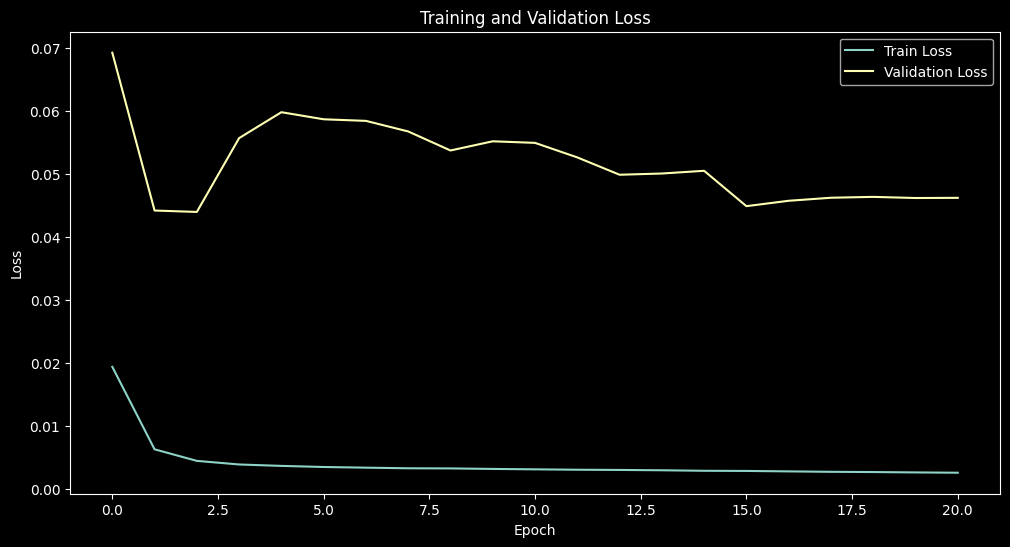

In [ ]:
# @title Plot Convergence
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
model = StockTransformer(num_encoder_layers=num_enc_layer, num_decoder_layers=num_dec_layer, emb_size=emb_size, dim_feedforward=dim_fwd, nhead=nhead, src_size=src_size, tgt_size=1)
model.load_state_dict(torch.load('/content/drive/Othercomputers/My Laptop/Documents/model_seq_log_minmaxscaler.pth', map_location=torch.device('cpu')))
model.to('cpu')

*   Below, I created the inference to test on my test data and return MSE, MAE and R^2
The data have to be unscaled.
I obtained some pretty good MAE and MSE, but R^2 is "Good" simply because it is not a relevant measure of performace in this case. It likely explains the delta of each points, but doesn't take into account the sequencing.

In [ ]:
# @title Inference on validation data
def inference(model, dataloader, input_scaler, output_scaler):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for src, tgt in dataloader:
            src = src.to(device)
            tgt = tgt.to(device)

            src_padding_mask = create_src_padding_mask(src, padding_values, device)
            output = model(src, src_padding_mask)

            valid_tgt_mask = tgt != padding_values
            output = output[valid_tgt_mask]
            tgt = tgt[valid_tgt_mask]

            predictions.append(output.cpu().numpy())
            targets.append(tgt.cpu().numpy())

            # print(predictions)
            # print(targets)
            # sys.exit(0)

    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    unscaled_predictions = output_scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)
    unscaled_targets = output_scaler.inverse_transform(targets.reshape(-1, 1)).reshape(targets.shape)

    unscaled_predictions_flat = unscaled_predictions.flatten()
    unscaled_targets_flat = unscaled_targets.flatten()
    mse = mean_squared_error(unscaled_targets_flat, unscaled_predictions_flat)
    mae = mean_absolute_error(unscaled_targets_flat, unscaled_predictions_flat)
    r2 = r2_score(unscaled_targets_flat, unscaled_predictions_flat)

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return unscaled_predictions, unscaled_targets

unscaled_predictions, unscaled_targets = inference(model, val_loader, input_scaler, output_scaler)


MSE: 91.4567
MAE: 8.1188
R2 Score: 0.9183


*   Then, we can visualize the performance of the model in the charts below.
The first and second one, show some pretty good results in terms of values. We will look later when it comes to predicting the sequence.
    *   The model is shows a positive correlation between predicted and target values.
    *   There are some deviation from the red line (where predicted = target values).
    *   The deviation is likely happening because of a lack of data in that range ($500+)

*   I repeated the plot function on the test data as well


Conclusion:
*   Clearly, more data would help, especially in the uncharted territories above $500
*   Residual plots shows at which range of data the model is underperforming

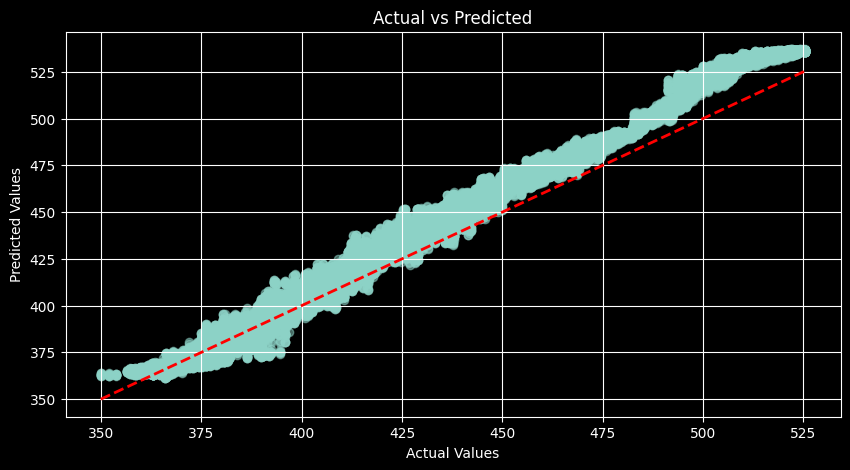

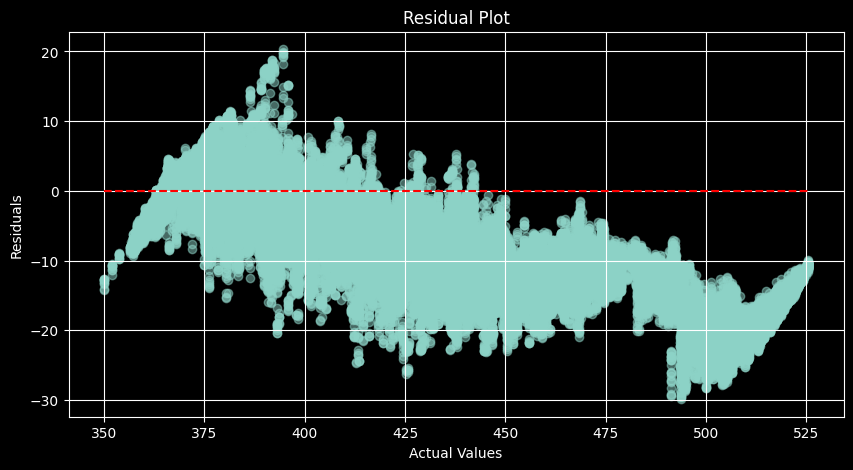

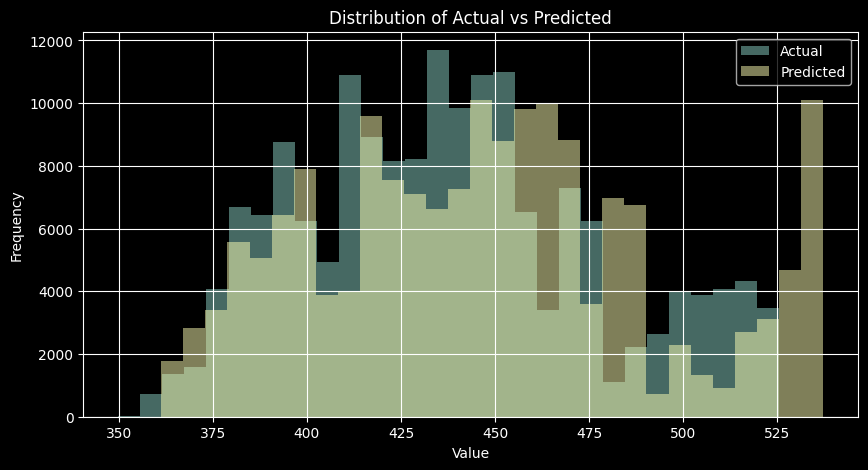

In [ ]:
# @title Plots Fit Actual/Predicted, Residuals, Histogram of Distribution for Test Data
def plot_scatter(targets, predictions, title='Actual vs Predicted'):
    plt.style.use('dark_background')
    plt.figure(figsize=(10, 5))
    plt.scatter(targets, predictions, alpha=0.5)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.grid(True)
    plt.show()
def plot_residuals(targets, predictions, title='Residual Plot'):
    residuals = targets - predictions
    plt.style.use('dark_background')
    plt.figure(figsize=(10, 5))
    plt.scatter(targets, residuals, alpha=0.5)
    plt.hlines(0, targets.min(), targets.max(), colors='r', linestyles='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.grid(True)
    plt.show()
def plot_histogram(targets, predictions, title='Distribution of Actual vs Predicted'):
    plt.style.use('dark_background')
    plt.figure(figsize=(10, 5))
    plt.hist(targets, bins=30, alpha=0.5, label='Actual')
    plt.hist(predictions, bins=30, alpha=0.5, label='Predicted')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

def evaluate_and_plot(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            src, tgt = batch
            src = src.to(device)
            tgt = tgt.to(device)
            src_padding_mask = create_src_padding_mask(src, padding_values, device)
            output = model(src, src_padding_mask)

            valid_tgt_mask = tgt != padding_values
            output = output[valid_tgt_mask]
            tgt = tgt[valid_tgt_mask]

            all_predictions.append(output.cpu().numpy())
            all_targets.append(tgt.cpu().numpy())

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Unscale predictions and targets
    unscaled_predictions = output_scaler.inverse_transform(all_predictions.reshape(-1, 1)).reshape(all_predictions.shape)
    unscaled_targets = output_scaler.inverse_transform(all_targets.reshape(-1, 1)).reshape(all_targets.shape)
    plot_scatter(unscaled_targets.flatten(), unscaled_predictions.flatten())
    plot_residuals(unscaled_targets.flatten(), unscaled_predictions.flatten())
    plot_histogram(unscaled_targets.flatten(), unscaled_predictions.flatten())

# evaluate_and_plot(model, val_loader, device)
evaluate_and_plot(model, test_loader, device)

*   A couple week later, I extracted new data to see how the model performs. The model has never been trained on these data. They are though, still in the range of $520 ish where we had the highest error in the training. These data will be scaled as well using MinMaxScaler.

In [12]:
# @title Data Prep for Inference on a new set of data
try:
    data_inf = pd.read_csv(file_inf)
    # Rename the 'time' column to 'date'
    data_inf.rename(columns={'time': 'date'}, inplace=True)
    for col in data_inf:
        if (col != 'market'):  # Skip the 'market' column
            data_inf[col] = pd.to_numeric(data_inf[col], errors='coerce')

    length_file1 = data_inf.shape[0]
    data_pp_inf = dfTradingAnalysis(data_inf.tail(length_file1 - 1))
    data_pp_inf = data_pp_inf.dropna()

except Exception as e:
    print(e)

########################################
shift_start_val = 0
shift_n = 1
def create_new_columns(data, shift_value, start):
  for i in range(start, shift_value + start):
    data[f"delta_vol{i+1}"] = data["volume"].pct_change(periods=i+1) * 100
  return data

data_pp_inf = create_new_columns(data_pp_inf, shift_n, shift_start_val)
data_pp_inf = data_pp_inf.dropna()

# Log returns
data_pp_inf['log_return'] = np.log(data_pp_inf['close'] / data_pp_inf['close'].shift(1))
data_pp_inf.dropna(subset=['log_return'], inplace=True)
########################################

range_rows = data_pp_inf.shape[0]
range_cols = data_pp_inf.shape[1]
print("Number rows:", range_rows)
print("Number Cols:", range_cols)

input_data_inf = []
output_data_inf = []
date_data_inf = []
range_rows_inf = data_pp_inf.shape[0]

for i in range(range_rows_inf):
    start_idx = i
    sequence_input = data_pp_inf.drop(columns=['close']).iloc[start_idx:start_idx + input_seq_length, 1:features_number].values.tolist()

    end_idx = start_idx + input_seq_length
    forecast_end_idx = end_idx + forecast_length

    sequence_output_value = data_pp_inf['close'].iloc[start_idx + forecast_length:forecast_end_idx].values if 'close' in data_pp_inf.columns else [0] * output_seq_length

    if len(sequence_output_value) >= output_seq_length:
        date = data_pp_inf.iloc[start_idx, 0]
        input_data_inf.append(sequence_input)
        output_data_inf.append(sequence_output_value[:output_seq_length])
        date_data_inf.append(date)

new_final_df = convertListtoDf(input_data_inf, output_data_inf, date_data_inf)


         date   market  granularity     low    high      open   close   volume
1  1714075200  SPY-USD         3600  503.12  508.39  503.4500  508.26  3988363
2  1714078800  SPY-USD         3600  503.49  508.35  508.3075  508.08   189367
3  1714082400  SPY-USD         3600  503.49  508.50  508.0900  507.47   282901
4  1714086000  SPY-USD         3600  506.85  507.43  507.3700  507.09    89186
0.016849994659423828
Number rows: 393
Number Cols: 14


After creating the sequences, we create a dataloader and feed the model to infer the sequences.
It shows a 0.94 R^2 which is really good. I did check how I calculated my R^2 and I believe the code is right

In [ ]:
# @title Applying Scaler and padding

#Applying the scaler I created earlier
new_final_df=applyScalerInOut(new_final_df, input_scaler, output_scaler)

# Calling the padding function created earlier
# Determine the maximum sequence lengths for input and output
max_input_len = max(len(seq) for seq in new_final_df['scaled_input'])
max_output_len = max(len(seq) for seq in new_final_df['scaled_output'])
max_pad_length = max(max_input_len, max_output_len)

# Pad the sequences
padded_inputs = pad_sequences(np.array(new_final_df['scaled_input'].tolist(), dtype=object), max_pad_length, padding_values)
padded_outputs = pad_sequences(np.array(new_final_df['scaled_output'].tolist(), dtype=object), max_pad_length, padding_values)

# Add the padded sequences back to the DataFrame
new_final_df['padded_input'] = pd.Series(padded_inputs)
new_final_df['padded_output'] = pd.Series(padded_outputs)

# Print the final DataFrame with padded sequences
# print(new_final_df[['date', 'input', 'scaled_input','padded_input', 'output', 'scaled_output', 'padded_output']].head())
# print(new_final_df.shape)

#Calling the same Dataloader
new_dataset = FinancialDataset(new_final_df, padding_values)
new_dataset_loader = DataLoader(new_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)


*   Calling the inference function below to measure MSE and MAE on our model



In [ ]:
# @title MAE and MSE on new set of data !
unscaled_predictions2_inf, unscaled_targets2_inf = inference(model, new_dataset_loader, input_scaler, output_scaler)

MSE: 10.1801
MAE: 2.6870
R2 Score: 0.8343


This shows the values only, without taking into account the sequence and time serie dependencies

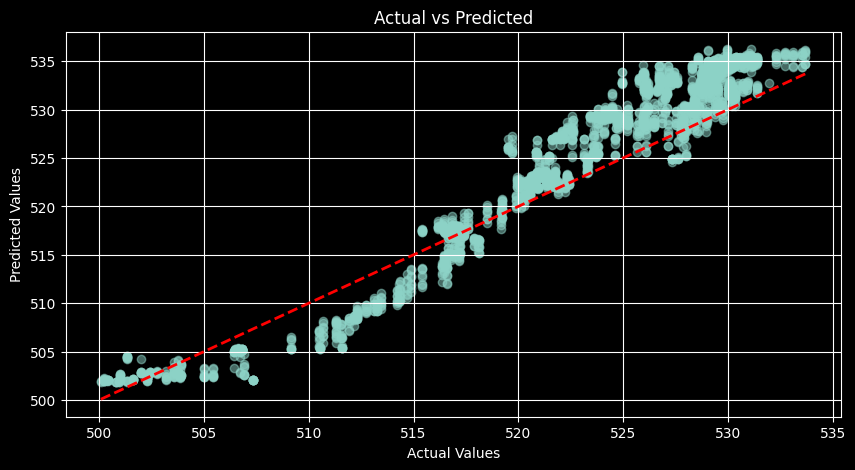

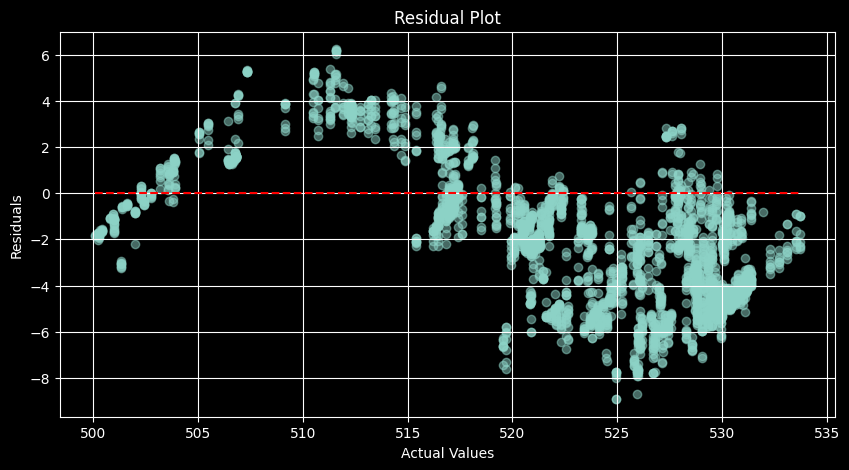

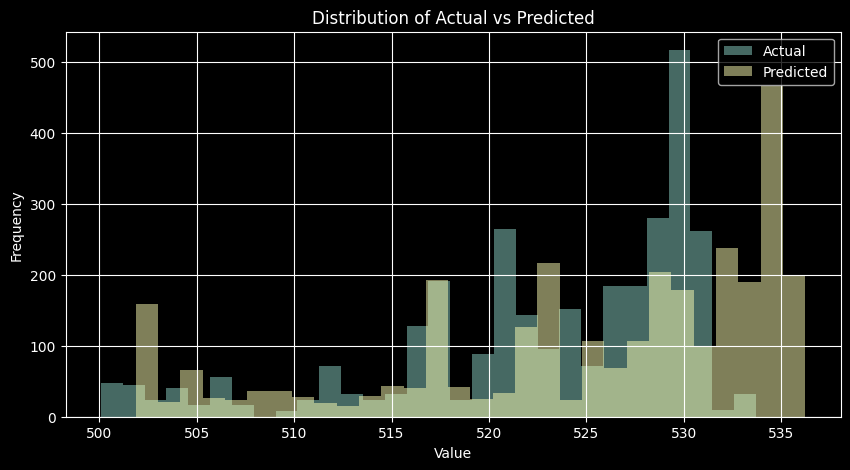

In [ ]:
# @title Plots Fit Actual/Predicted, Residuals, Histogram of Distribution for Test Data
evaluate_and_plot(model, new_dataset_loader, device)

*   Below we see the sequences. And it shows some the lag in the sequence prediction. A lag that seems to be of one time step. Which is not bad.
*   With this limited number of data, the model was able to catch some trends.
*   The cool part is that, because we trained with different sequence lengths, shifts and target lengths, we can infer using the lengths of our choice. Any lenght different than the model was trained with will likely have more error (that's actually something worth to look at).

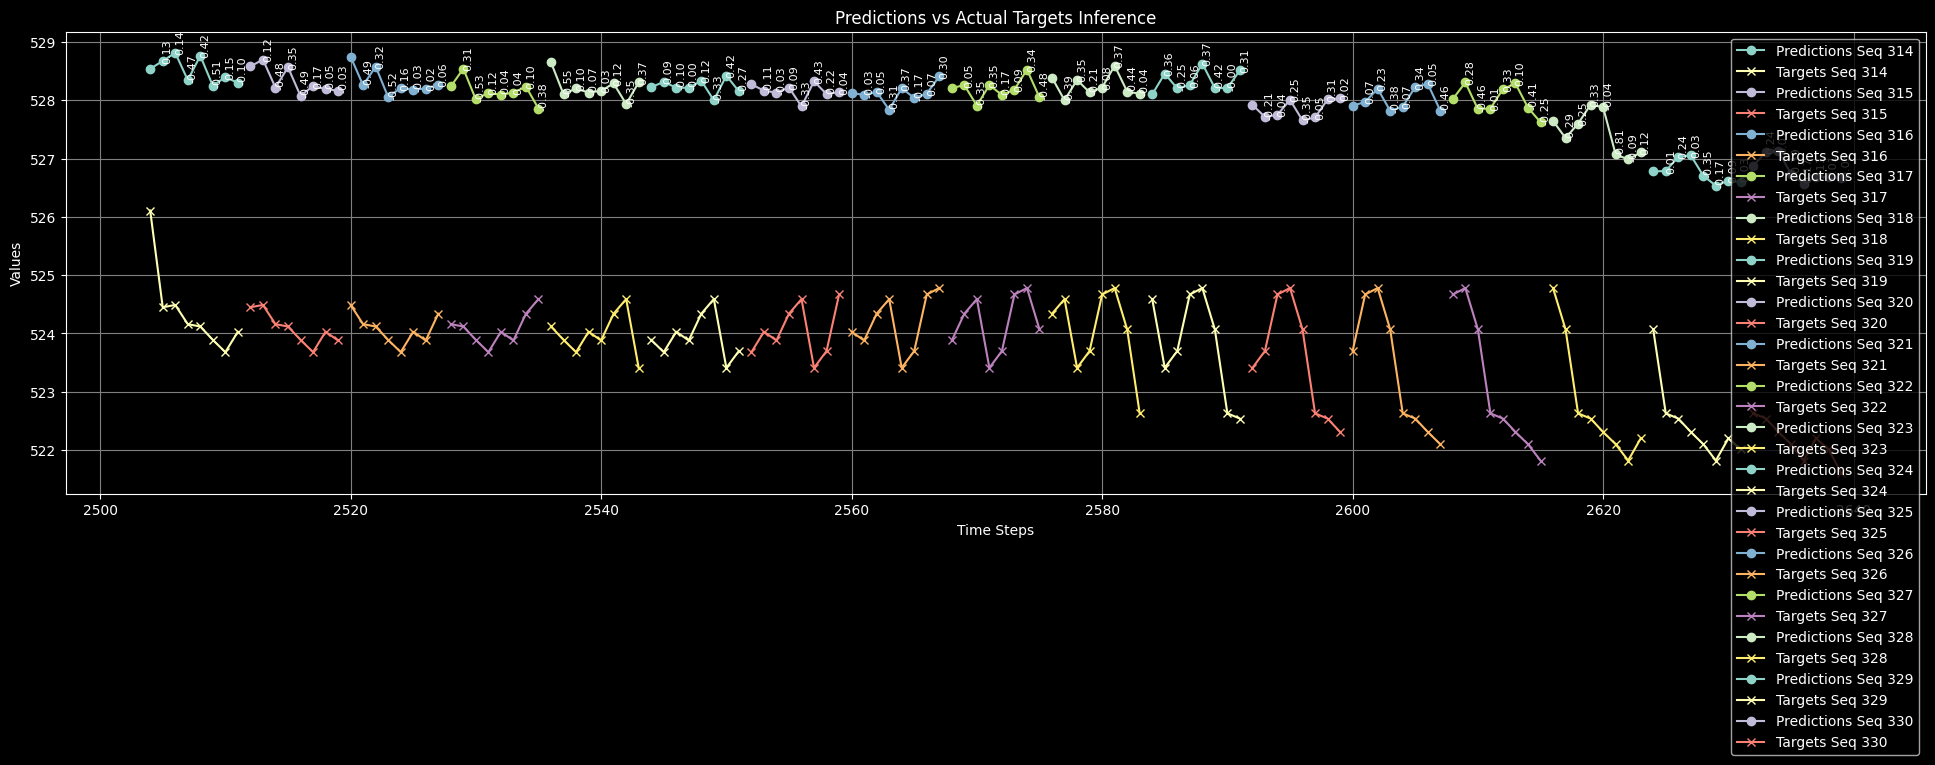

In [ ]:
# @title Plot 35 sequences
def plot_predictions_vs_targets(predictions, targets, sequence_length=4):
    predictions = np.array(predictions)
    targets = np.array(targets)
    sequence_length = sequence_length
    nbre_last_seq_to_see = 35

    num_sequences = len(predictions) // sequence_length

    plt.style.use('dark_background')
    plt.figure(figsize=(24, 6))

    for i in range(num_sequences - nbre_last_seq_to_see*2, round(num_sequences - nbre_last_seq_to_see*1.5)): #for i in range(num_sequences - nbre_last_seq_to_see*2, num_sequences):
        start_idx = i * sequence_length
        end_idx = start_idx + sequence_length

        # # Plot predictions and targets with different markers to distinguish sequences
        plt.plot(range(start_idx, end_idx), predictions[start_idx:end_idx], label=f'Predictions Seq {i+1}', marker='o')
        plt.plot(range(start_idx, end_idx), targets[start_idx:end_idx], label=f'Targets Seq {i+1}', marker='x')

        # Calculate and display deltas
        for j in range(start_idx, end_idx):
            if j < end_idx - 1:
                delta = predictions[j + 1] - predictions[j]
                plt.text(j+1, predictions[j+1], f'{delta:.2f}', color='white', fontsize=8, rotation = 'vertical')

    plt.rcParams['figure.figsize'] = (24, 6)
    plt.title('Predictions vs Actual Targets Inference', color='white')
    plt.xlabel('Time Steps', color='white')
    plt.ylabel('Values', color='white')
    plt.legend()
    plt.grid(True, color='gray')
    plt.show()

plot_predictions_vs_targets(unscaled_predictions2_inf, unscaled_targets2_inf, output_seq_length)

Below, is a closer look at the infered sequences. We used the setup
input_seq_length = 10
forecast_length = 3
output_seq_length = 8

So we used 10 historical values, and with forecast_length and output_seq_length of 3 and 8 respectively, we predict an output of sequence 8 but because of a shift of 3, we end up predicting only 1 future value of interest.

It shows some pretty good trends overall. Out of 6 sequences displayed, 2 predicted the last value with the wrong trend (sequence4 and 5 below)

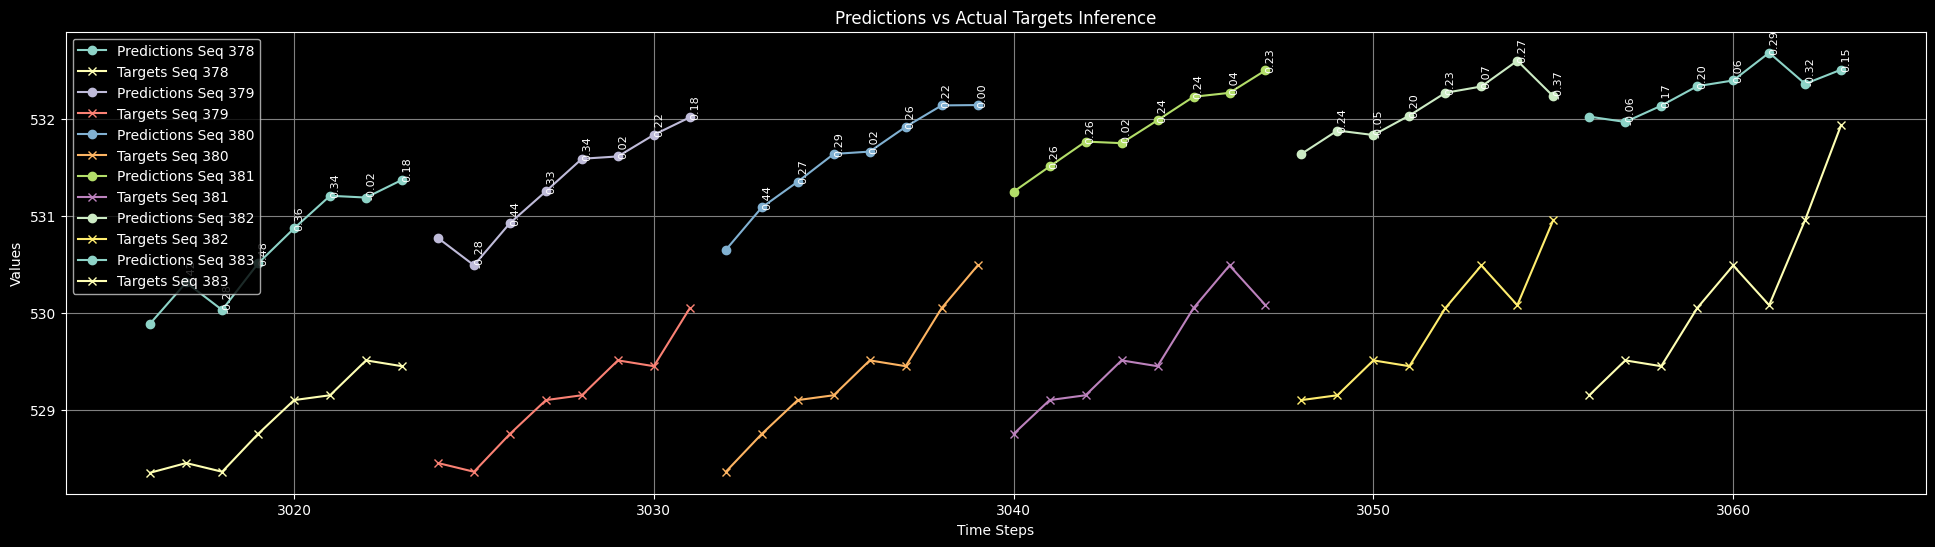

In [ ]:
# @title Plot last 6 sequences
def plot_predictions_vs_targets(predictions, targets, sequence_length=4):
    predictions = np.array(predictions)
    targets = np.array(targets)
    sequence_length = sequence_length
    nbre_last_seq_to_see = 3

    num_sequences = len(predictions) // sequence_length

    plt.style.use('dark_background')
    plt.figure(figsize=(24, 6))

    for i in range(num_sequences - nbre_last_seq_to_see*2, num_sequences):
        start_idx = i * sequence_length
        end_idx = start_idx + sequence_length

        # # Plot predictions and targets with different markers to distinguish sequences
        plt.plot(range(start_idx, end_idx), predictions[start_idx:end_idx], label=f'Predictions Seq {i+1}', marker='o')
        plt.plot(range(start_idx, end_idx), targets[start_idx:end_idx], label=f'Targets Seq {i+1}', marker='x')

        # Calculate and display deltas
        for j in range(start_idx, end_idx):
            if j < end_idx - 1:
                delta = predictions[j + 1] - predictions[j]
                plt.text(j+1, predictions[j+1], f'{delta:.2f}', color='white', fontsize=8, rotation = 'vertical')

    plt.rcParams['figure.figsize'] = (24, 6)
    plt.title('Predictions vs Actual Targets Inference', color='white')
    plt.xlabel('Time Steps', color='white')
    plt.ylabel('Values', color='white')
    plt.legend()
    plt.grid(True, color='gray')
    plt.show()

plot_predictions_vs_targets(unscaled_predictions2_inf, unscaled_targets2_inf, output_seq_length)